# Drivebuddy Assignment - Pavbhaji or No-Pavbhaji Classification


<h3> Problem Statement </h3> The goal here is to train a model that can text classify whether a given image is of pavbhaji or not

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import os
import math
from sklearn.metrics import confusion_matrix
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.regularizers import l1, l2, L1L2
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random,os,glob
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D,Dense, Dropout,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform #, conditional
from keras.utils import np_utils
import keras
import tensorflow as tf
from keras.datasets import fashion_mnist
import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D, Dropout,Flatten,Dense,Activation,BatchNormalization

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import _locale
_locale._getdefaultlocale = (lambda *args: ['en_US', 'utf8'])

In [3]:
# Set GPU
physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:

import json
with open(r"D:\Study\JOB\PAVBHAJI\dataset\pavbhaji.json", encoding="utf8") as f:
    data = json.load(f)

In [5]:
data[0]

{'dimensions': {'height': 734, 'width': 640},
 'display_url': 'https://instagram.fpnq3-1.fna.fbcdn.net/vp/352198856dbdacba4b84a4a9a77ad087/5B8644A9/t51.2885-15/e15/37599530_291077411445016_3382263118984904704_n.jpg',
 'edge_liked_by': {'count': 3797},
 'edge_media_preview_like': {'count': 3797},
 'edge_media_to_caption': {'edges': [{'node': {'text': 'TAG A PAV BHAJI FANATIC 😋😍 PC @exploringplates For more food updates follow @ekplate To get featured tag us on your pictures ❤ .\n.\n#ekplate #nomnom #nom #delhi_igers #eeeeeats #foodaholic #foodblogger #foodphotography #foodcoma #foodgram #things2doinmumbai #foodblog #foodgasm #foodlove #india  #foodie #yummy  #bombay #mumbai #delhi #pune  #bangalore #streetfood  #ekplatepavbhaji #butter #vadapav #pavbhaji #mumbaifood'}}]},
 'edge_media_to_comment': {'count': 52},
 'id': '1834712933156555738',
 'is_video': True,
 'location': None,
 'owner': {'id': '1919686029'},
 'shortcode': 'Bl2NbElnIva',
 'tags': ['vadapav',
  'foodgram',
  'foodphotog

##### The Jason file contains information about each image, e.g. - id, tags, owner, etc. This information doesn't seem much useful from the training perspect. 

## Exploratory data analysis

In [6]:
data_path = r"D:\Study\JOB\PAVBHAJI\dataset"
pav_path = os.path.join(data_path, r"images\1")
no_pav_path = os.path.join(data_path, r"images\0")
os.chdir(pav_path)
pav_img = len([name for name in os.listdir('.') if os.path.isfile(name)])
os.chdir(no_pav_path)
no_pav_img = len([name for name in os.listdir('.') if os.path.isfile(name)])
total = pav_img + no_pav_img

In [7]:
total

453

Pavbhaji Images  183 , ( 40.397350993377486 %)
Non-Pavbhaji Images  270 , ( 59.60264900662252 %)


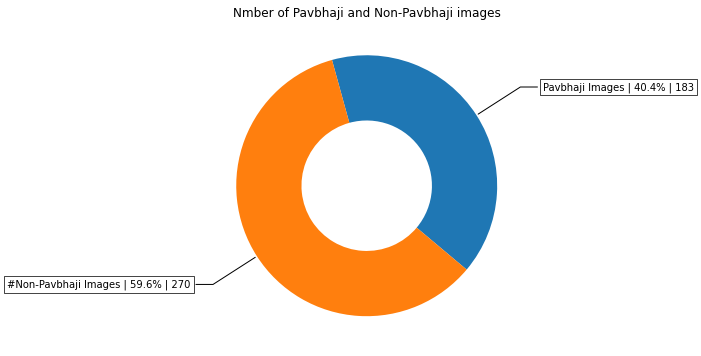

In [8]:
print("Pavbhaji Images ", pav_img, ", (", (pav_img/(pav_img+no_pav_img))*100,"%)")
print("Non-Pavbhaji Images ", no_pav_img, ", (", (no_pav_img/(pav_img+no_pav_img))*100,"%)")

pav_p =    str(round((pav_img/(pav_img+no_pav_img))*100, 2)) + '%'
no_pav_p = str(round((no_pav_img/(pav_img+no_pav_img))*100, 2)) + '%'

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

recipe = ["Pavbhaji Images | " + pav_p + " | " + str(pav_img), "#Non-Pavbhaji Images | " + no_pav_p + " | " + str(no_pav_img)]

data = [pav_img, no_pav_img]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of Pavbhaji and Non-Pavbhaji images")

plt.show()

<b>The image dataset is imbalanced. But in most of the ML problems, it is been seen that an imbalancee of 40-60% is most often ignored.</b>

### Studying Picture Quality, labels, Noise in data

In [9]:
pav_image = glob.glob(r"D:\Study\JOB\PAVBHAJI\dataset\images\1" + r"\*")
no_pav_image = glob.glob(r"D:\Study\JOB\PAVBHAJI\dataset\images\0" + r"\*") 

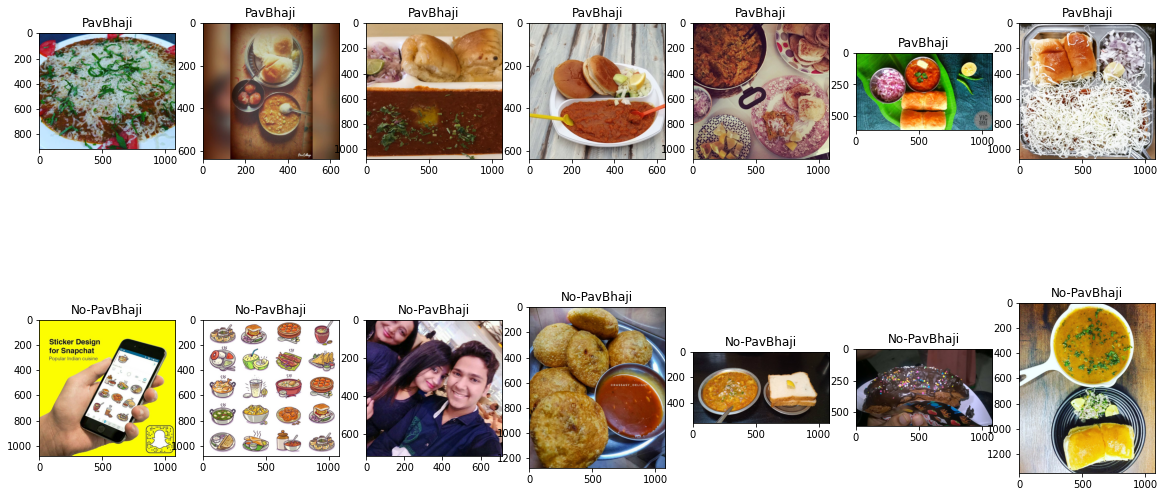

In [10]:
n = 7
fig, axes = plt.subplots(2,n,figsize=(20,10))
for i in range(n):
    axes[0, i].imshow(plt.imread(pav_image[i]))
    axes[0, i].set_title('PavBhaji')
    axes[1, i].imshow(plt.imread(no_pav_image[i]))
    axes[1, i].set_title('No-PavBhaji')

<b> Let's get an idea of the images of the 2 categories. As we see here, the quality of the images is desecnt: with different background (noise), different lightings (e.g. In 5th Pavbhaji image, there are many other dishes kept along with Pavbhaji). </b>

### Studying image sizes

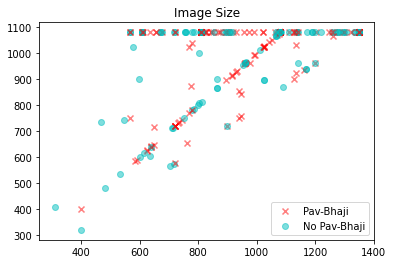

In [11]:
for i in range(len(pav_image)):
    h1,w1,c1 = plt.imread(pav_image[i]).shape
    h2,w2,c2 = plt.imread(no_pav_image[i]).shape
    plt.scatter(h1,w1,c='r',marker='x',alpha=0.5)
    plt.scatter(h2,w2,c='c',marker='o',alpha=0.5)
plt.title('Image Size')
plt.legend(('Pav-Bhaji','No Pav-Bhaji'))

<b>The images are of different sizes and aspect ratio, with at least one side of 512 pixels.</b>

## Splitting dataset into - TRAIN TEST & CV

In [12]:
from os import listdir
from os.path import isfile, join
mypath = r"D:\Study\JOB\PAVBHAJI\dataset\images\1"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
pav_files = pd.DataFrame()
pav_files['file_name'] = onlyfiles
pav_files['src_path'] = r"D:\Study\JOB\PAVBHAJI\dataset\images\1"
pav_files['is_pav'] = 1

mypath = r"D:\Study\JOB\PAVBHAJI\dataset\images\0"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
no_pav_files = pd.DataFrame()
no_pav_files['file_name'] = onlyfiles
no_pav_files['src_path'] = r"D:\Study\JOB\PAVBHAJI\dataset\images\0"
no_pav_files['is_pav'] = 0

all_image = pd.concat([pav_files, no_pav_files])


In [13]:
pav_files.head(3)

file_name  \
0  16228666_180901469054785_6854217108004274176_n...   
1  20590186_1136380956463100_8896999366112313344_...   
2  34874678_217155915753039_6705436451573596160_n...   

                                 src_path  is_pav  
0  D:\Study\JOB\PAVBHAJI\dataset\images\1       1  
1  D:\Study\JOB\PAVBHAJI\dataset\images\1       1  
2  D:\Study\JOB\PAVBHAJI\dataset\images\1       1

In [14]:
no_pav_files.head(3)

file_name  \
0  24274012_2042365482666908_6941195371183865856_...   
1  25007049_1999304547019423_8482995541326692352_...   
2  34372850_1661761887275993_1422925813375827968_...   

                                 src_path  is_pav  
0  D:\Study\JOB\PAVBHAJI\dataset\images\0       0  
1  D:\Study\JOB\PAVBHAJI\dataset\images\0       0  
2  D:\Study\JOB\PAVBHAJI\dataset\images\0       0

<b>Divide both class into 70-15-15 size for TRAIN-CV-TEST Split</b>

In [15]:
split_1 = .7
split_2 = .85

pav_files.loc[pav_files.index < math.floor(len(pav_files)*split_1), 'dest_path'] = r"D:\Study\JOB\PAVBHAJI\dataset\train\pavbhaji" 
pav_files.loc[((pav_files.index >= math.floor(len(pav_files)*split_1)) & (pav_files.index < math.floor(len(pav_files)*split_2))), 'dest_path'] = r"D:\Study\JOB\PAVBHAJI\dataset\valid\pavbhaji" 
pav_files.loc[((pav_files.index >= math.floor(len(pav_files)*split_2)) & (pav_files.index < math.floor(len(pav_files)*1))), 'dest_path'] = r"D:\Study\JOB\PAVBHAJI\dataset\test\pavbhaji" 

In [16]:
pav_files.value_counts('dest_path')

dest_path
D:\Study\JOB\PAVBHAJI\dataset\train\pavbhaji    128
D:\Study\JOB\PAVBHAJI\dataset\test\pavbhaji      28
D:\Study\JOB\PAVBHAJI\dataset\valid\pavbhaji     27
dtype: int64

In [17]:
no_pav_files.loc[no_pav_files.index < math.floor(len(no_pav_files)*split_1), 'dest_path'] = r"D:\Study\JOB\PAVBHAJI\dataset\train\not_pavbhaji" 
no_pav_files.loc[((no_pav_files.index >= math.floor(len(no_pav_files)*split_1)) & (no_pav_files.index < math.floor(len(no_pav_files)*split_2))), 'dest_path'] = r"D:\Study\JOB\PAVBHAJI\dataset\valid\not_pavbhaji" 
no_pav_files.loc[((no_pav_files.index >= math.floor(len(no_pav_files)*split_2)) & (no_pav_files.index < math.floor(len(no_pav_files)*1))), 'dest_path'] = r"D:\Study\JOB\PAVBHAJI\dataset\test\not_pavbhaji"

In [18]:
no_pav_files.value_counts('dest_path')

dest_path
D:\Study\JOB\PAVBHAJI\dataset\train\not_pavbhaji    189
D:\Study\JOB\PAVBHAJI\dataset\test\not_pavbhaji      41
D:\Study\JOB\PAVBHAJI\dataset\valid\not_pavbhaji     40
dtype: int64

In [19]:
import shutil
def copy_files(src, dest):
    shutil.copy(src, dest)

In [20]:
for ind in pav_files.index:
    #print(df['Name'][ind], df['Stream'][ind])
    src = pav_files["src_path"][ind] + "\\" + pav_files["file_name"][ind]
    dest = pav_files["dest_path"][ind]
    copy_files(src, dest)

In [21]:
for ind in no_pav_files.index:
    #print(df['Name'][ind], df['Stream'][ind])
    src = no_pav_files["src_path"][ind] + "\\" + no_pav_files["file_name"][ind]
    dest = no_pav_files["dest_path"][ind]
    copy_files(src, dest)

## Data Preparation

<b> Since the data set for each class is relatively small to train a good neural network, an image data generator from Keras is used for image tranformation to expand the dataset and to reduce the overfitting problem. </b>

In [22]:
path = r"D:\Study\JOB\PAVBHAJI\dataset"

In [40]:
def data():
    path = r"D:\Study\JOB\PAVBHAJI\dataset"

    train_datagen = ImageDataGenerator(
            rescale = 1./255,
            rotation_range = 20,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            horizontal_flip = True,
            vertical_flip = True,
            fill_mode='nearest')

    validation_datagen = ImageDataGenerator(
            rescale = 1./255)

    test_datagen = ImageDataGenerator(
            rescale = 1./255)

    img_shape = (224, 224, 3) # default values

    train_batch_size = 64 #64
    val_batch_size = 32 #32

    train_generator = train_datagen.flow_from_directory(
                directory = path + '/train', 
                target_size = (img_shape[0], img_shape[1]),
                batch_size = train_batch_size,
                class_mode = 'categorical',
                color_mode="rgb",
                shuffle = True,
                seed=42) 

    validation_generator = validation_datagen.flow_from_directory(
                directory = path + '/valid',
                target_size = (img_shape[0], img_shape[1]),
                batch_size = val_batch_size,
                class_mode = 'categorical',
                color_mode="rgb",
                shuffle = True) #False

    test_generator = test_datagen.flow_from_directory(
                directory = path + '/test',
                target_size = (img_shape[0], img_shape[1]),
                batch_size = 1,
                class_mode = None,
                color_mode="rgb",
                shuffle = False)
    
    return train_generator, validation_generator, test_generator 

In [41]:
train_generator, validation_generator, test_generator = data()

Found 317 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


In [42]:
for image_batch, label_batch in train_generator:
    break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 2))

In [43]:
print ("Train_generator",train_generator.class_indices)
print ("Validation_generator",validation_generator.class_indices)
print ("Test_generator",test_generator.class_indices)
labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
    f.write(labels)
labels = dict((v,k) for k,v in train_generator.class_indices.items())
print("Our Labels",labels)

Train_generator {'not_pavbhaji': 0, 'pavbhaji': 1}
Validation_generator {'not_pavbhaji': 0, 'pavbhaji': 1}
Test_generator {'not_pavbhaji': 0, 'pavbhaji': 1}
Our Labels {0: 'not_pavbhaji', 1: 'pavbhaji'}


In [44]:
def Visualize(image,label):
    fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
    for (img, classs, c_ax) in zip(image, label, m_axs.flatten()):
        img = np.squeeze(img)
        c_ax.imshow(img)
        c_ax.set_title('%s' % labels[np.argmax(classs)])
        c_ax.axis('off')

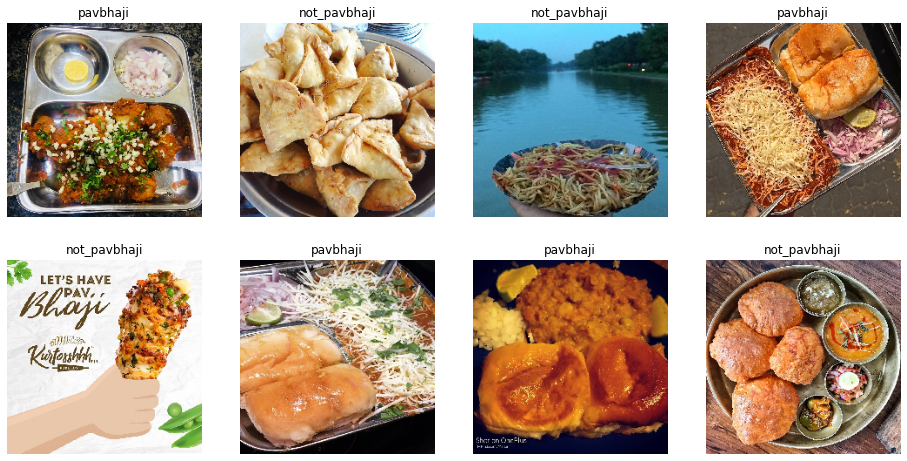

In [45]:
image,label = next(validation_generator)
Visualize(image,label)

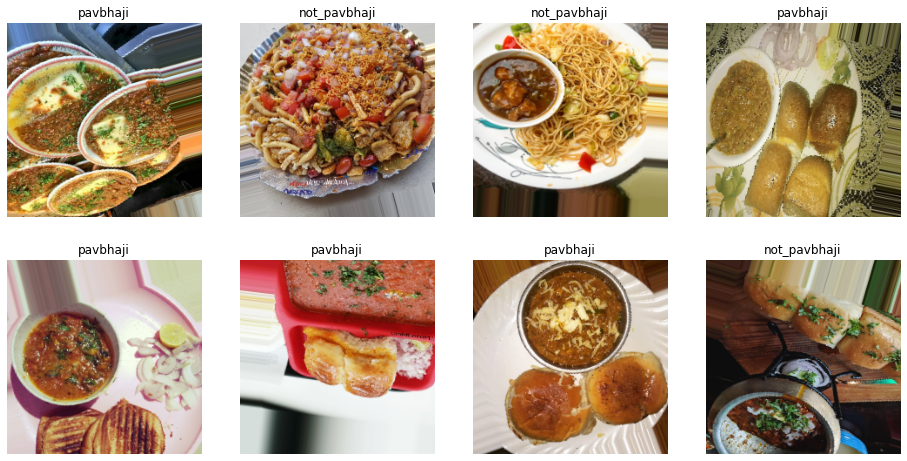

In [46]:
image,label = next(train_generator)
Visualize(image,label)

## Hyperparameter Tuning - Search Best Parameter

In [47]:
from tensorflow.keras.applications import InceptionV3
#from tensorflow.keras.applications import VGG16
#from tensorflow.keras.applications import ResNet50

def model(train_generator, validation_generator):

    epochs = 20
    #counter = 0;
    nb_train_samples = train_generator.samples
    nb_validation_samples = validation_generator.samples
    train_batch_size = train_generator.batch_size
    validation_batch_size = validation_generator.batch_size

    img_shape = (224, 224, 3) # default values

    inception = InceptionV3(weights = 'imagenet', include_top = False, input_shape = img_shape)
    #print("Number of layers in the inception model: ", len(inception.layers))
    # Freeze the layers except the last 30 layers
    for layer in inception.layers[:-30]:
        layer.trainable = False

    model = Sequential()

    # Add the convolutional base model
    model.add(inception)
    model.add(Conv2D(32, 3, activation={{choice(['relu', 'sigmoid'])}}))# kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(GlobalAveragePooling2D())
    # Add new layers
    model.add(Flatten())

    model.add(Dense({{choice([512, 1024])}}, activation={{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense({{choice([512, 1024])}}, activation={{choice(['relu', 'sigmoid'])}}))

    if {{choice(['two', 'three'])}} == 'three':
        model.add(Dense({{choice([128, 256])}}))
        model.add(Activation({{choice(['relu', 'sigmoid'])}}))
        model.add(Dropout({{uniform(0, 1)}}))

    # last layer
    model.add(Dense(2, activation='softmax', kernel_regularizer=l2({{choice([10**-3, 10**-2, 10**-1])}})))

    adam = keras.optimizers.Adam(lr={{choice([10**-3, 10**-2, 10**-1])}})
    rmsprop = keras.optimizers.RMSprop(lr={{choice([10**-3, 10**-2, 10**-1])}})
    sgd = keras.optimizers.SGD(lr={{choice([10**-3, 10**-2, 10**-1])}})

    choiceval = {{choice(['adam', 'rmsprop'])}}
    if choiceval == 'adam':
        optim = adam
    else:
        optim = rmsprop

    model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=15)
    #checkpointer = ModelCheckpoint(filepath=r"MNIST_FASHION_CHECK\MNIST_FASHION_CHK_POINT-{val_loss:02f}-{epoch:02d}.hdf5", verbose=1, save_best_only=False)
    checkpointer = ModelCheckpoint(filepath=r"PAVBHAJI\BEST_PAVBHAJI_CHK_POINT.hdf5", verbose=1, save_best_only=True)
    log_csv = CSVLogger(r"PAVBHAJI\LOG_PAVBHAJI.csv", separator = ',', append = False)
    
    start = time.time()
    
    model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // train_batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=[early_stopping, checkpointer, log_csv],
            validation_steps=nb_validation_samples // validation_batch_size)
    
    end = time.time()
    print('Execution time: ', end-start)

    score, acc = model.evaluate_generator(generator=validation_generator, steps=nb_validation_samples // validation_batch_size)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [48]:
pwd

'C:\\Users\\bhatt\\OneDrive\\My_PROGRAM\\DRIVE_BUDDY'

In [49]:
train_generator, validation_generator, test_generator = data()
start = time.time()

import os
MODEL_PATH = "C:\Users\bhatt\OneDrive\My_PROGRAM\DRIVE_BUDDY\PAVBHAJI"
filepath = os.path.join(MODEL_PATH,'BEST_PAVBHAJI_V2.h5')
If not os.path.exists(MODEL_PATH): #determine whether it exists
    Os.makedirs(MODEL_PATH) #Create if it does not exist
best_run, best_model = optim.minimize(model=model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=10,
                                          trials=Trials(),
                                          notebook_name='WRK_DL_HYPER_INCEPTION')
end = time.time()
print('Execution time: ', end-start)

Found 317 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 68 images belonging to 2 classes.
>>> Imports:
#coding=utf-8

try:
    import tensorflow.compat.v1 as tf
except:
    pass

try:
    import os
except:
    pass

try:
    import math
except:
    pass

try:
    from sklearn.metrics import confusion_matrix
except:
    pass

try:
    import keras
except:
    pass

try:
    from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
except:
    pass

try:
    from tensorflow.keras.regularizers import l1, l2, L1L2
except:
    pass

try:
    from keras.models import Sequential, load_model
except:
    pass

try:
    from keras.callbacks import ModelCheckpoint
except:
    pass

try:
    from keras.applications.inception_v3 import InceptionV3, preprocess_input
except:
    pass

try:
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
except:
    pass

try:
    import random, os, glob
except:
    pass

try

C:\Users\bhatt\Anaconda3\envs\tf2.4\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '



Epoch 1/20                                            
1/4 [======>.......................]                  
 - ETA: 10s - batch: 0.0000e+00 - size: 64.0000 - loss: 1.2517 - acc: 0.2969
                                                     
2/4 [==============>...............]                  
 - ETA: 0s - batch: 0.5000 - size: 62.5000 - loss: 1.8403 - acc: 0.4240     
                                                      
3/4 [=====================>........]                  
 - ETA: 0s - batch: 1.0000 - size: 63.0000 - loss: 1.8379 - acc: 0.4921
                                                      
4/4 [==============================]                  
 - ETA: 0s - batch: 1.5000 - size: 63.2500 - loss: 1.7762 - acc: 0.5138
  0%|          | 0/10 [00:13<?, ?trial/s, best loss=?]

C:\Users\bhatt\Anaconda3\envs\tf2.4\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



                                                      
Epoch 00001: val_loss improved from inf to 1.25951, saving model to PAVBHAJI\BEST_PAVBHAJI_CHK_POINT.hdf5
                                                      
4/4 [==============================]                  
 - 7s 1s/step - batch: 1.5000 - size: 63.2500 - loss: 1.7762 - acc: 0.5138 - val_loss: 1.2595 - val_acc: 0.5938

Epoch 2/20                                            
1/4 [======>.......................]                  
 - ETA: 0s - batch: 0.0000e+00 - size: 64.0000 - loss: 1.4041 - acc: 0.5156
                                                      
2/4 [==============>...............]                  
 - ETA: 2s - batch: 0.5000 - size: 64.0000 - loss: 1.1729 - acc: 0.5938    
                                                      
3/4 [=====================>........]                  
 - ETA: 1s - batch: 1.0000 - size: 64.0000 - loss: 1.1111 - acc: 0.5833
                                                      
4/4 [==

Epoch 9/20                                            
1/4 [======>.......................]                  
 - ETA: 1s - batch: 0.0000e+00 - size: 64.0000 - loss: 0.6837 - acc: 0.6094
                                                      
2/4 [==============>...............]                  
 - ETA: 2s - batch: 0.5000 - size: 62.5000 - loss: 0.6728 - acc: 0.6320    
                                                      
3/4 [=====================>........]                  
 - ETA: 1s - batch: 1.0000 - size: 63.0000 - loss: 0.7083 - acc: 0.5873
                                                      
4/4 [==============================]                  
 - ETA: 0s - batch: 1.5000 - size: 62.5000 - loss: 0.7202 - acc: 0.5440
                                                      
Epoch 00009: val_loss did not improve from 0.69044
                                                      
4/4 [==============================]                  
 - 5s 1s/step - batch: 1.5000 - size: 62.5000 - 

C:\Users\bhatt\Anaconda3\envs\tf2.4\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:1273: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Epoch 1/20                                                             
1/4 [======>.......................]                                   
 - ETA: 11s - batch: 0.0000e+00 - size: 64.0000 - loss: 0.7590 - acc: 0.5000
                                                                      
2/4 [==============>...............]                                   
 - ETA: 0s - batch: 0.5000 - size: 64.0000 - loss: 15.3935 - acc: 0.4766    
                                                                      
3/4 [=====================>........]                                   
 - ETA: 0s - batch: 1.0000 - size: 64.0000 - loss: 13.9532 - acc: 0.4323
                                                                      
4/4 [==============================]                                   
 - ETA: 0s - batch: 1.5000 - size: 64.0000 - loss: 10.9261 - acc: 0.5000
                                                                       
Epoch 00001: val_loss improved from inf to 1.08590, sav

                                                                       
Epoch 00013: val_loss did not improve from 0.67344
                                                                       
4/4 [==============================]                                   
 - 4s 1s/step - batch: 1.5000 - size: 63.2500 - loss: 0.6878 - acc: 0.5613 - val_loss: 0.6786 - val_acc: 0.5938

Epoch 14/20                                                            
1/4 [======>.......................]                                   
 - ETA: 1s - batch: 0.0000e+00 - size: 64.0000 - loss: 0.6704 - acc: 0.6094
                                                                       
2/4 [==============>...............]                                   
 - ETA: 2s - batch: 0.5000 - size: 64.0000 - loss: 0.6627 - acc: 0.6328    
                                                                       
3/4 [=====================>........]                                   
 - ETA: 1s - batch: 1.0000 - size: 6

3/4 [=====================>........]                                   
 - ETA: 1s - batch: 1.0000 - size: 64.0000 - loss: 2.7487 - acc: 0.5521
                                                                       
4/4 [==============================]                                   
 - ETA: 0s - batch: 1.5000 - size: 63.2500 - loss: 2.3974 - acc: 0.5336
                                                                       
Epoch 00006: val_loss did not improve from 1.43372
                                                                       
4/4 [==============================]                                   
 - 4s 1s/step - batch: 1.5000 - size: 63.2500 - loss: 2.3974 - acc: 0.5336 - val_loss: 1.8632 - val_acc: 0.4062

Epoch 7/20                                                             
1/4 [======>.......................]                                   
 - ETA: 0s - batch: 0.0000e+00 - size: 64.0000 - loss: 1.8426 - acc: 0.5312
                                        

                                                                       
3/4 [=====================>........]                                   
 - ETA: 0s - batch: 1.0000 - size: 64.0000 - loss: 2.1545 - acc: 0.5521
                                                                       
4/4 [==============================]                                   
 - ETA: 0s - batch: 1.5000 - size: 64.0000 - loss: 2.1649 - acc: 0.5234
                                                                       
Epoch 00019: val_loss did not improve from 0.83732
                                                                       
4/4 [==============================]                                   
 - 4s 1s/step - batch: 1.5000 - size: 64.0000 - loss: 2.1649 - acc: 0.5234 - val_loss: 3.6783 - val_acc: 0.5938

Epoch 20/20                                                            
1/4 [======>.......................]                                   
 - ETA: 1s - batch: 0.0000e+00 - size: 64.00

Epoch 12/20                                                            
1/4 [======>.......................]                                   
 - ETA: 1s - batch: 0.0000e+00 - size: 64.0000 - loss: 0.4294 - acc: 0.7656
                                                                       
2/4 [==============>...............]                                   
 - ETA: 2s - batch: 0.5000 - size: 64.0000 - loss: 0.4409 - acc: 0.7656    
                                                                       
3/4 [=====================>........]                                   
 - ETA: 1s - batch: 1.0000 - size: 63.0000 - loss: 0.4694 - acc: 0.7407
                                                                       
4/4 [==============================]                                   
 - ETA: 0s - batch: 1.5000 - size: 63.2500 - loss: 0.4719 - acc: 0.7470
                                                                       
Epoch 00012: val_loss did not improve from 0.60425
     

                                                                        
4/4 [==============================]                                    
 - 5s 2s/step - batch: 1.5000 - size: 63.2500 - loss: 5.0919 - acc: 0.5494 - val_loss: 1.1493 - val_acc: 0.5938

Epoch 5/20                                                              
1/4 [======>.......................]                                    
 - ETA: 1s - batch: 0.0000e+00 - size: 64.0000 - loss: 2.7844 - acc: 0.5312
                                                                        
2/4 [==============>...............]                                    
 - ETA: 2s - batch: 0.5000 - size: 62.5000 - loss: 3.8467 - acc: 0.4560    
                                                                        
3/4 [=====================>........]                                    
 - ETA: 1s - batch: 1.0000 - size: 63.0000 - loss: 3.5261 - acc: 0.4974 
                                                                        
4/4 [

Epoch 11/20                                                             
1/4 [======>.......................]                                    
 - ETA: 1s - batch: 0.0000e+00 - size: 64.0000 - loss: 1.0995 - acc: 0.5000
                                                                        
2/4 [==============>...............]                                    
 - ETA: 2s - batch: 0.5000 - size: 64.0000 - loss: 1.0826 - acc: 0.5547    
                                                                        
3/4 [=====================>........]                                    
 - ETA: 1s - batch: 1.0000 - size: 63.0000 - loss: 2.0732 - acc: 0.5926 
                                                                        
4/4 [==============================]                                    
 - ETA: 0s - batch: 1.5000 - size: 63.2500 - loss: 1.9064 - acc: 0.5850 
                                                                        
Epoch 00011: val_loss improved from 1.04878 t

3/4 [=====================>........]                                    
 - ETA: 1s - batch: 1.0000 - size: 64.0000 - loss: 1.3775 - acc: 0.5260 
                                                                        
4/4 [==============================]                                    
 - ETA: 0s - batch: 1.5000 - size: 64.0000 - loss: 1.4647 - acc: 0.5078 
                                                                        
Epoch 00003: val_loss improved from 1.03104 to 1.01404, saving model to PAVBHAJI\BEST_PAVBHAJI_CHK_POINT.hdf5
                                                                        
4/4 [==============================]                                    
 - 5s 1s/step - batch: 1.5000 - size: 64.0000 - loss: 1.4647 - acc: 0.5078 - val_loss: 1.0140 - val_acc: 0.4062

Epoch 4/20                                                              
1/4 [======>.......................]                                    
 - ETA: 0s - batch: 0.0000e+00 - size: 64.0000 

4/4 [==============================]                                    
 - 4s 1s/step - batch: 1.5000 - size: 63.2500 - loss: 0.7312 - acc: 0.5889 - val_loss: 0.7440 - val_acc: 0.5938

Epoch 16/20                                                             
1/4 [======>.......................]                                    
 - ETA: 1s - batch: 0.0000e+00 - size: 64.0000 - loss: 0.7597 - acc: 0.5781
                                                                        
2/4 [==============>...............]                                    
 - ETA: 2s - batch: 0.5000 - size: 64.0000 - loss: 0.7389 - acc: 0.6016    
                                                                        
3/4 [=====================>........]                                    
 - ETA: 1s - batch: 1.0000 - size: 63.0000 - loss: 0.7396 - acc: 0.5873 
                                                                        
4/4 [==============================]                                    
 - ET

                                                                        
3/4 [=====================>........]                                    
 - ETA: 1s - batch: 1.0000 - size: 63.0000 - loss: 0.6741 - acc: 0.8201 
                                                                        
4/4 [==============================]                                    
 - ETA: 0s - batch: 1.5000 - size: 62.5000 - loss: 0.6481 - acc: 0.8280 
                                                                        
Epoch 00008: val_loss did not improve from 0.77481
                                                                        
4/4 [==============================]                                    
 - 5s 1s/step - batch: 1.5000 - size: 62.5000 - loss: 0.6481 - acc: 0.8280 - val_loss: 0.9227 - val_acc: 0.7344

Epoch 9/20                                                              
1/4 [======>.......................]                                    
 - ETA: 1s - batch: 0.0000e+00 - 

 - ETA: 23s - batch: 0.0000e+00 - size: 64.0000 - loss: 2.3667 - acc: 0.4531
                                                                       
2/4 [==============>...............]                                    
 - ETA: 0s - batch: 0.5000 - size: 64.0000 - loss: 3.8858 - acc: 0.5000     
                                                                        
3/4 [=====================>........]                                    
 - ETA: 0s - batch: 1.0000 - size: 63.0000 - loss: 3.8532 - acc: 0.5132 
                                                                        
4/4 [==============================]                                    
 - ETA: 0s - batch: 1.5000 - size: 63.2500 - loss: 3.7703 - acc: 0.5613 
                                                                        
Epoch 00001: val_loss improved from inf to 1.31617, saving model to PAVBHAJI\BEST_PAVBHAJI_CHK_POINT.hdf5
                                                                        
4/4 [======

                                                                        
4/4 [==============================]                                    
 - ETA: 0s - batch: 1.5000 - size: 63.2500 - loss: 0.7020 - acc: 0.6047 
                                                                        
Epoch 00013: val_loss improved from 0.70605 to 0.70462, saving model to PAVBHAJI\BEST_PAVBHAJI_CHK_POINT.hdf5
                                                                        
4/4 [==============================]                                    
 - 5s 1s/step - batch: 1.5000 - size: 63.2500 - loss: 0.7020 - acc: 0.6047 - val_loss: 0.7046 - val_acc: 0.5938

Epoch 14/20                                                             
1/4 [======>.......................]                                    
 - ETA: 1s - batch: 0.0000e+00 - size: 64.0000 - loss: 0.7144 - acc: 0.5625
                                                                        
2/4 [==============>...............]        

                                                                        
4/4 [==============================]                                    
 - 5s 1s/step - batch: 1.5000 - size: 63.2500 - loss: 6.1866 - acc: 0.5771 - val_loss: 1.0891 - val_acc: 0.5938

Epoch 6/20                                                              
1/4 [======>.......................]                                    
 - ETA: 1s - batch: 0.0000e+00 - size: 64.0000 - loss: 4.9557 - acc: 0.4688
                                                                        
2/4 [==============>...............]                                    
 - ETA: 2s - batch: 0.5000 - size: 64.0000 - loss: 4.5618 - acc: 0.4453    
                                                                        
3/4 [=====================>........]                                    
 - ETA: 1s - batch: 1.0000 - size: 64.0000 - loss: 3.7600 - acc: 0.5052 
                                                                        
4/4 [

Epoch 12/20                                                             
1/4 [======>.......................]                                    
 - ETA: 0s - batch: 0.0000e+00 - size: 64.0000 - loss: 2.5231 - acc: 0.5938
                                                                        
2/4 [==============>...............]                                    
 - ETA: 2s - batch: 0.5000 - size: 62.5000 - loss: 1.8045 - acc: 0.5600    
                                                                        
3/4 [=====================>........]                                    
 - ETA: 1s - batch: 1.0000 - size: 63.0000 - loss: 1.8831 - acc: 0.5714 
                                                                        
4/4 [==============================]                                    
 - ETA: 0s - batch: 1.5000 - size: 63.2500 - loss: 1.7006 - acc: 0.5652 
                                                                        
Epoch 00012: val_loss improved from 1.02793 t

 - ETA: 2s - batch: 0.5000 - size: 62.5000 - loss: 0.7121 - acc: 0.4480    
                                                                        
3/4 [=====================>........]                                    
 - ETA: 1s - batch: 1.0000 - size: 63.0000 - loss: 0.7229 - acc: 0.4074 
                                                                        
4/4 [==============================]                                    
 - ETA: 0s - batch: 1.5000 - size: 63.2500 - loss: 0.7268 - acc: 0.4387 
                                                                        
Epoch 00004: val_loss did not improve from 0.70107
                                                                        
4/4 [==============================]                                    
 - 5s 2s/step - batch: 1.5000 - size: 63.2500 - loss: 0.7268 - acc: 0.4387 - val_loss: 0.7046 - val_acc: 0.5938

Epoch 5/20                                                              
1/4 [======>..................

 - 6s 2s/step - batch: 1.5000 - size: 63.2500 - loss: 0.6799 - acc: 0.5968 - val_loss: 0.6784 - val_acc: 0.5938

Epoch 17/20                                                             
1/4 [======>.......................]                                    
 - ETA: 1s - batch: 0.0000e+00 - size: 64.0000 - loss: 0.6766 - acc: 0.5938
                                                                        
2/4 [==============>...............]                                    
 - ETA: 2s - batch: 0.5000 - size: 64.0000 - loss: 0.6963 - acc: 0.5469    
                                                                        
3/4 [=====================>........]                                    
 - ETA: 1s - batch: 1.0000 - size: 64.0000 - loss: 0.6910 - acc: 0.5729 
                                                                        
4/4 [==============================]                                    
 - ETA: 0s - batch: 1.5000 - size: 64.0000 - loss: 0.6887 - acc: 0.5742 
     

In [118]:
# create another generator for all test images in a single batch 
img_shape = (224, 224, 3) # default values

test_datagen = ImageDataGenerator(
            rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
                directory = path + '/test',
                target_size = (img_shape[0], img_shape[1]),
                batch_size = 70,
                color_mode="rgb",
                shuffle = False)

nb_test_samples = test_generator.samples

Found 68 images belonging to 2 classes.


In [80]:
best_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
conv2d_759 (Conv2D)          (None, 3, 3, 32)          589856    
_________________________________________________________________
dropout_19 (Dropout)         (None, 3, 3, 32)          0         
_________________________________________________________________
global_average_pooling2d_7 ( (None, 32)                0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1024)              33792     
_________________________________________________________________
dropout_20 (Dropout)         (None, 1024)             

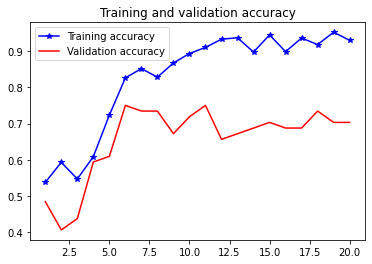

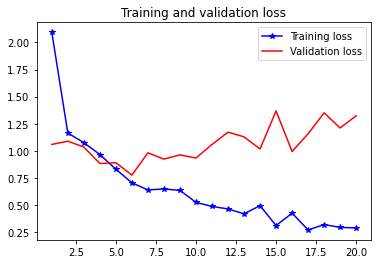

In [125]:
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'b*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Result Evaluation

In [126]:
def load_img(img_path):
    from keras.preprocessing import image
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)/255.0
    
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    return(img)

In [151]:
def prediction(img, model):
    #model = tf.keras.models.load_model("inception.h5")
    p = model.predict(img[np.newaxis, ...])
    classes=[]
    prob=[]
    print("====================================")
    print("Probability for one image loaded")
    print("====================================")
    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
    print("====================================\n")

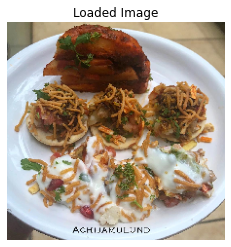

In [152]:
img = load_img(path +'/test/Not_PavBhaji/39809477_925464760975925_8358097373316653940_n.jpg')

In [153]:
prediction(img, best_model)

Probability for one image loaded
NOT_PAVBHAJI : 100.0 %
PAVBHAJI : 0.0 %



Probability for one image loaded
NOT_PAVBHAJI : 0.03 %
PAVBHAJI : 99.97 %



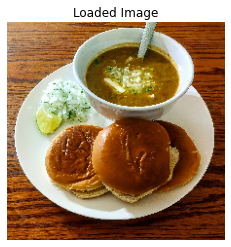

In [155]:
img = load_img(path +'/test/pavBhaji/39687850_880003475522102_6357917552298950656_n.jpg')
prediction(img, best_model)

In [157]:
x_test, y_test = test_generator.next()
y_pred_conf = best_model.predict(x_test) #return probabilities of each class
y_pred = np.argmax(y_pred_conf,axis=1)
y_label = np.argmax(y_test,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_pred,y_label)*100))

Accuracy score: 73.5%


In [164]:
#Also we can use evaluate generator to get accuracy percentage, but it comparatively slower

#vaidation_batch_size = 1
#score, acc = best_model.evaluate_generator(generator=test_generator, steps=nb_test_samples // vaidation_batch_size)
#print('Accuracy score: {:.1f}%'.format(acc*100))

Accuracy score: 73.5%


### Randomly checking 5 images

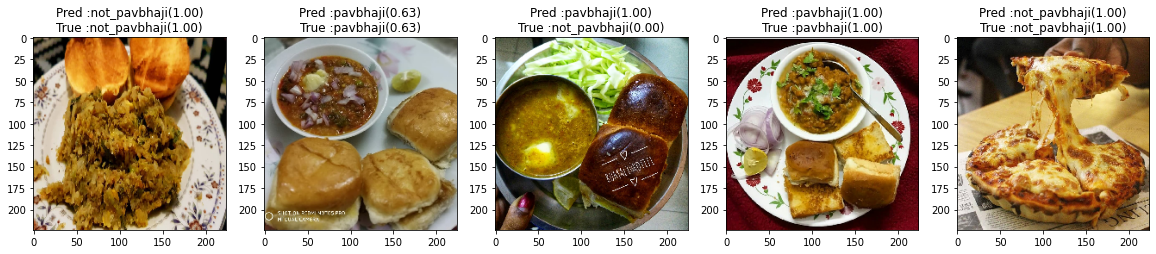

In [166]:
ind = np.random.randint(1,len(x_test),5)
classtolabel = {'1':'pavbhaji','0':'not_pavbhaji'}
f, ax=plt.subplots(1,5,figsize=(20,10))
for i,j in enumerate(ind):
    ax[i].imshow(x_test[j])
    ax[i].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                          (classtolabel[str(y_pred[j])],np.max(y_pred_conf[j]),
                           classtolabel[str(y_label[j])],y_pred_conf[j][(y_label[j])],fontweight="bold", size=20))

### Confusion Matrix

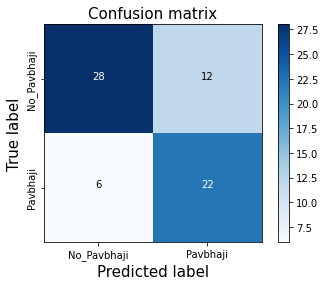

In [167]:
def plot_confusion_matrix(cm):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix',fontsize=15)
    plt.colorbar()
    classes = ['No_Pavbhaji','Pavbhaji']
    plt.xticks([0,1], classes, fontsize=10)
    plt.yticks([0,1], classes, fontsize=10,rotation=90,verticalalignment="center")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > np.max(cm)/2. else "black")
    plt.xlabel('Predicted label',fontsize=15)
    plt.ylabel('True label',fontsize=15)
    
plot_confusion_matrix(confusion_matrix(y_label,y_pred))

## ROC Curve

In [168]:
fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict() # area under roc curve
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_conf[:, i]) # roc_curve function apply to binary class only
    roc_auc[i] = auc(fpr[i], tpr[i])  # using the trapezoidal rule to get area under curve

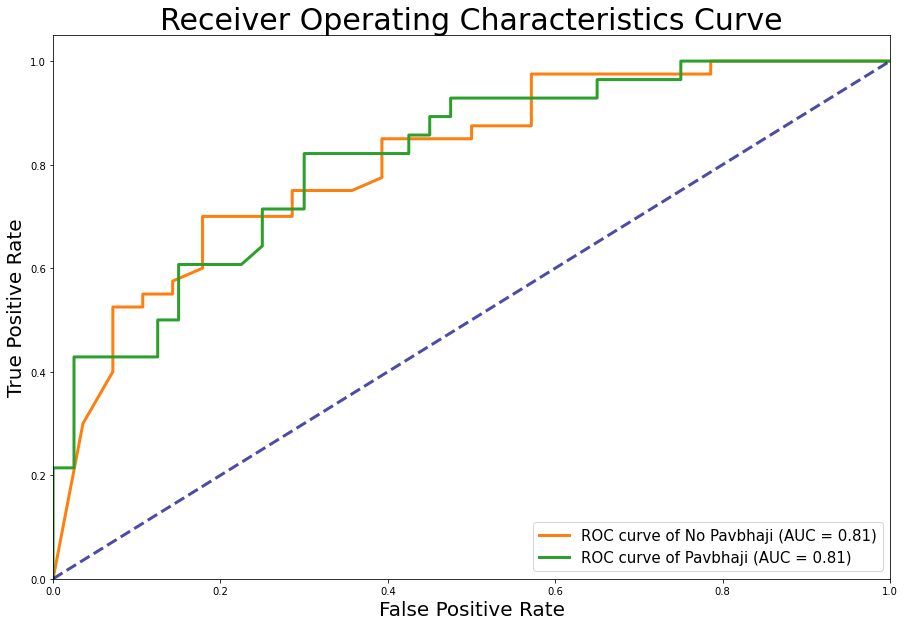

In [169]:
def plot_roc(fpr,tpr,roc_auc):
    plt.figure(figsize=(15,10))
    plt.plot(fpr[0], tpr[0], color='C1', lw=3, label='ROC curve of No Pavbhaji (AUC = %0.2f)' % roc_auc[0])
    plt.plot(fpr[1], tpr[1], color='C2', lw=3, label='ROC curve of Pavbhaji (AUC = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--',alpha=0.7)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=20)
    plt.ylabel('True Positive Rate',fontsize=20)
    plt.title('Receiver Operating Characteristics Curve',fontsize=30)
    plt.legend(loc="lower right",fontsize=15)
    plt.show()

plot_roc(fpr,tpr,roc_auc)

## Inspect the predictions with wrong label

In [170]:
# find the wrong-est label (largest confidence wrong label)
def show_wrongest_label(x_test,y_test,y_pred_conf):
    y_pred = np.argmax(y_pred_conf,axis=1) # convert predictions to labels
    y_label = np.argmax(y_test,axis=1) # convert answer to labels

    errors = (y_pred - y_label != 0) # find booleans of wrong predictions
    y_pred_errors = y_pred_conf[errors] #the probabilities of the wrong Y_pred [0.5,0.2,0.3]

    y_pred_classes_errors = y_pred[errors] # the wrong pred label [2]
    y_pred_errors_prob = np.max(y_pred_errors,axis = 1) # Probabilities of the wrong predicted numbers [0.5]

    y_true_classes_errors = y_label[errors] # the true label [0]
    y_true_errors_prob = np.diagonal(np.take(y_pred_errors, y_true_classes_errors, axis=1)) # Predicted prob of the true values in the error set[0.2]

    img_errors = x_test[errors] # image of each errors

    # Difference between the probability of the predicted label and the true label
    delta_pred_true_errors = y_pred_errors_prob - y_true_errors_prob
    # Get index of delta prob errors in ascending order
    sorted_delta_errors = np.argsort(delta_pred_true_errors)
    # The index of top 15 errors 
    most_important_errors = sorted_delta_errors[-15:]
    
    
    def display_errors(errors_index,img_errors,pred_errors, obs_errors):
        n = 0
        nrows = 3
        ncols = 5
        fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
        fig.set_figheight(20)
        fig.set_figwidth(30)
        for row in range(nrows):
            for col in range(ncols):
                error = errors_index[n]
                ax[row,col].imshow((img_errors[error]))
                ax[row,col].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                                      (classtolabel[pred_errors[error].astype('str')],y_pred_errors_prob[error],
                                       classtolabel[obs_errors[error].astype('str')],y_true_errors_prob[error]),
                                      fontweight="bold", size=20)
                n += 1
    
    display_errors(most_important_errors, img_errors, y_pred_classes_errors, y_true_classes_errors)

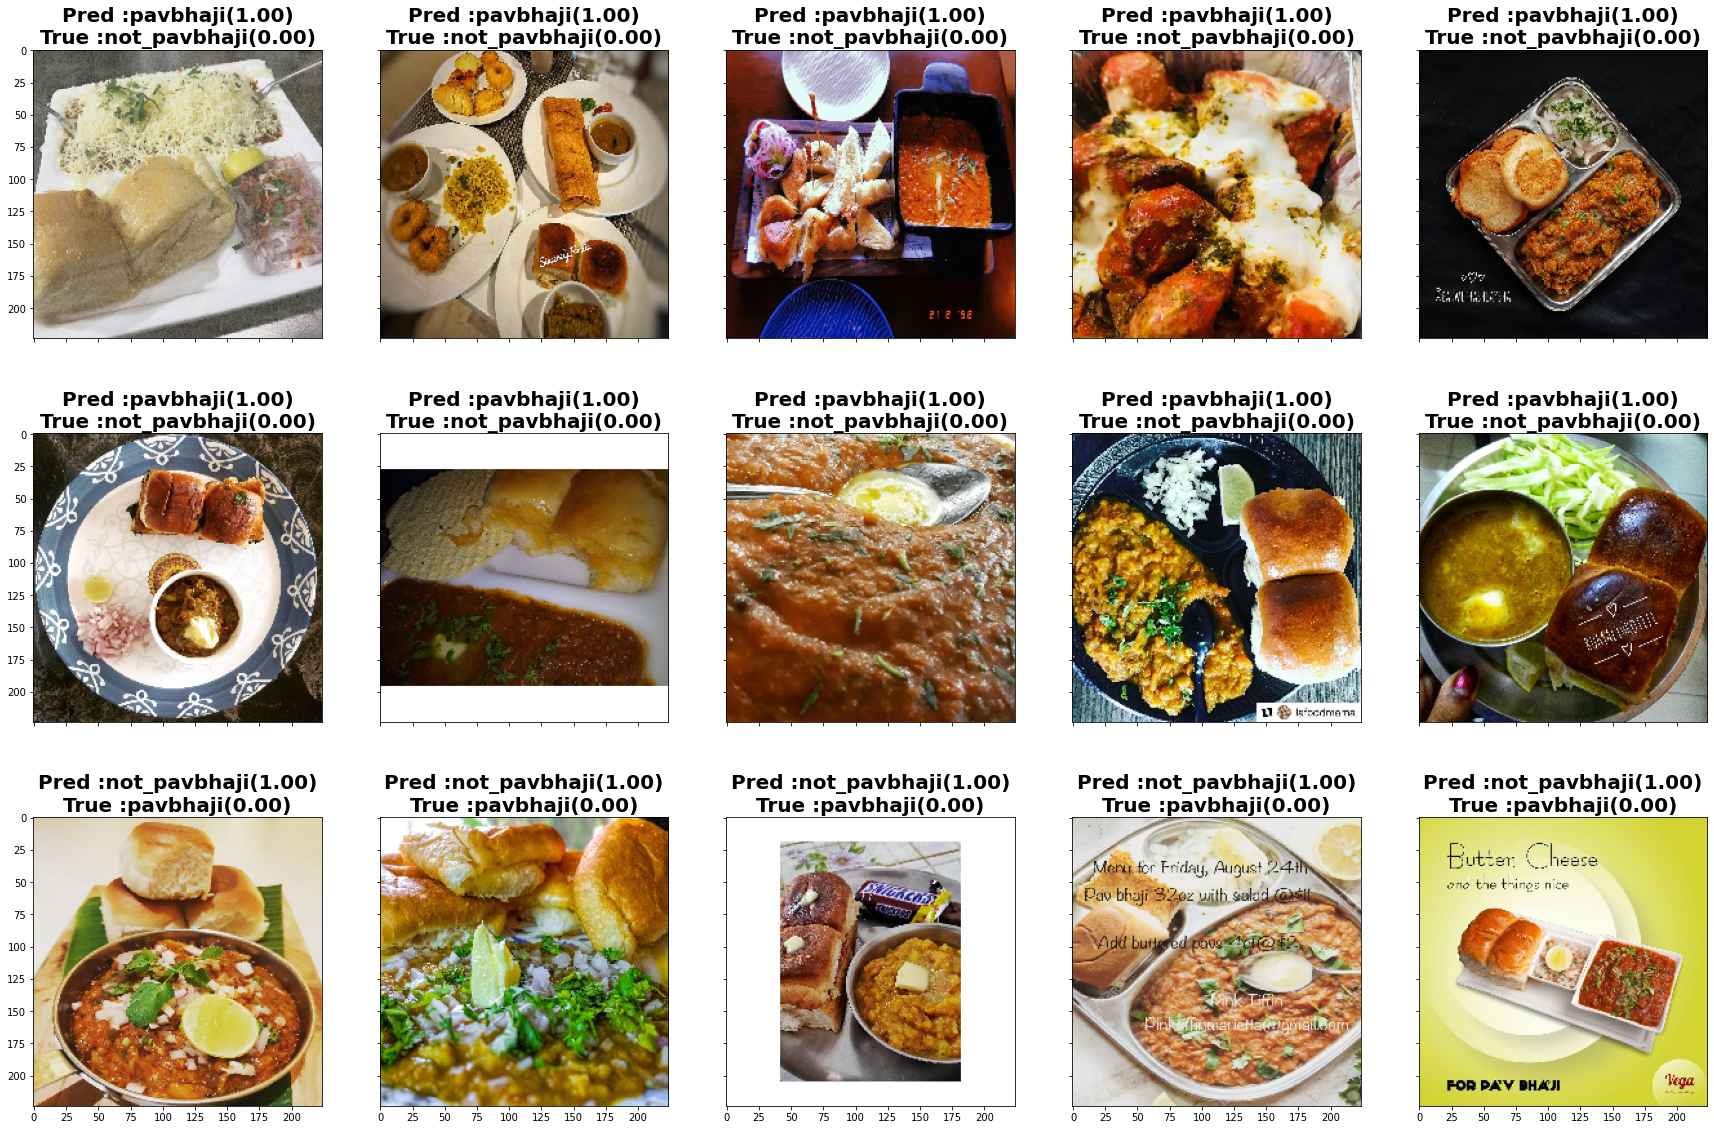

In [171]:
show_wrongest_label(x_test,y_test,y_pred_conf)

## Summary

__1. Model is performing decently good with accuracy 73.5% and AUC for both positive and negative samples is 0.81.__<br/>
__2. Number of samples is way too less to train a deep neural network.__ <br/>